# Multi-period OPF example

Multi-period OPF example with and without ESR.

No update on renewable generation and electrification load.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from nygrid.nygrid import NYGrid
from nygrid.plots import plot_gen

In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

Grid data directory: /mnt/Bo_HDD/NYgrid-python/data/grid
Figure directory: /mnt/Bo_HDD/NYgrid-python/figures
Results directory: /mnt/Bo_HDD/NYgrid-python/results


## Read grid data

### Read generator profiles

In [3]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2019, 1, 1, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')

# Read load profile
load_profile = pd.read_csv(os.path.join(grid_data_dir, f'load_profile_{start_date.year}.csv'),
                           parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

# Read generation profile
gen_profile = pd.read_csv(os.path.join(grid_data_dir, f'gen_profile_{start_date.year}.csv'),
                          parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

# Read generator capacity limit profile
genmax_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmax_profile_{start_date.year}.csv'),
                             parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

genmin_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmin_profile_{start_date.year}.csv'),
                             parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

# Read generator ramp rate profile
genramp30_profile = pd.read_csv(os.path.join(grid_data_dir, f'genramp30_profile_{start_date.year}.csv'),
                                parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

# Read generator cost profile (linear)
gencost0_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost0_profile_{start_date.year}.csv'),
                               parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

gencost1_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost1_profile_{start_date.year}.csv'),
                               parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

In [4]:
load_profile.sum(axis=1).sort_values(ascending=False)

TimeStamp
2018-08-29 16:00:00    93203.379573
2018-08-29 15:00:00    93195.481205
2018-08-28 16:00:00    93096.897866
2018-08-28 17:00:00    92926.644148
2018-08-29 14:00:00    92834.789049
                           ...     
2018-05-13 05:00:00    35697.114653
2018-10-14 04:00:00    35637.438092
2018-05-14 03:00:00    35606.429683
2018-05-13 03:00:00    35419.794164
2018-05-13 04:00:00    35330.279322
Length: 8760, dtype: float64

### Read DC line and ESR properties

In [5]:
# Read DC line property file
filename = os.path.join(grid_data_dir, 'dcline_prop.csv')
dcline_prop = pd.read_csv(filename)
dcline_prop

,DC_F_BUS,DC_T_BUS,DC_BR_STATUS,DC_PF,DC_PT,DC_QF,DC_QT,DC_VF,DC_VT,DC_PMIN,DC_PMAX,DC_QMINF,DC_QMAXF,DC_QMINT,DC_QMAXT,LOSS0,LOSS1,FROM_ZONE,TO_ZONE
0,21,80,1,12.666667,0,0,0,1.01,1,-530,530,-100,100,-100,100,0,0,NE,K
1,124,79,1,660.000000,0,0,0,1.01,1,-660,660,-100,100,-100,100,0,0,PJM,K
2,125,81,1,599.166667,0,0,0,1.01,1,-660,660,-100,100,-100,100,0,0,PJM,J
3,125,81,1,223.166667,0,0,0,1.01,1,-660,660,-100,100,-100,100,0,0,PJM,J
4,48,81,1,0.000000,0,0,0,1.01,1,-1250,1250,-100,100,-100,100,0,0,D,J
5,69,81,1,0.000000,0,0,0,1.01,1,-1300,1300,-100,100,-100,100,0,0,E,J


In [6]:
filename = os.path.join(grid_data_dir, 'esr_prop.csv')
esr_prop = pd.read_csv(filename)
esr_prop

,ESR_NAME,ESR_BUS,ESR_STATUS,ESR_CRG_MAX,ESR_DIS_MAX,ESR_CRG_EFF,ESR_DIS_EFF,ESR_SOC_MIN,ESR_SOC_MAX,ESR_SOC_INI,ESR_SOC_TGT,ESR_CRG_COST,ESR_DIS_COST,ESR_ZONE
0,Gilboa 1 (IIFO - 1/1/2019),42,1,280.0,291.8,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
1,Gilboa 2,42,1,280.0,292.7,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
2,Gilboa 3,42,1,280.0,291.9,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
3,Gilboa 4,42,1,280.0,292.5,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
4,Lewiston PS,56,1,230.0,240.0,0.59,0.59,0,2880,1440,1440,0.005,0.005,A
5,North County Energy Storage,47,1,20.0,20.0,0.85,0.85,0,200,100,100,0.005,0.005,E
6,zzAgg_J_ES__1,82,1,2.0,2.0,0.85,0.85,0,8,4,4,0.005,0.005,J
7,zzAgg_K_FC__1,80,1,18.5,18.5,0.85,0.85,0,74,37,37,0.005,0.005,K
8,A_ESR_Standalone,56,1,300.0,300.0,0.85,0.85,0,1200,600,600,0.005,0.005,A
9,B_ESR_Standalone,53,1,180.0,180.0,0.85,0.85,0,720,360,360,0.005,0.005,B


## Multi-period OPF

### Without initial conditions

In [7]:
# Only run for one day
d = 240
start_datetime = timestamp_list[d]
end_datetime = start_datetime + timedelta(hours=47)
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-08-29 00:00:00
End time: 2018-08-30 23:00:00


#### Without ESR

In [8]:
# Create NYGrid object
nygrid_sim_wo_esr = NYGrid(grid_data_dir,
                           start_datetime=start_datetime,
                           end_datetime=end_datetime,
                           dcline_prop=dcline_prop,
                           esr_prop=None,
                           vre_prop=None,
                           verbose=True)

# Set load and generation time series data
nygrid_sim_wo_esr.set_load_sch(load_profile)
nygrid_sim_wo_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_wo_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_wo_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_wo_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_wo_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_wo_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_wo_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_wo_esr.set_options(options)

# Solve DC OPF
nygrid_sim_wo_esr.solve_dc_opf()

# Get results
results_0_wo_esr = nygrid_sim_wo_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmp_5edlv53.pyomo.lp
Reading time = 0.27 seconds
x1: 80250 rows, 65521 columns, 403182 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 80250 rows, 65521 columns and 403182 nonzeros
Model fingerprint: 0x0ad7ce8c
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 73909 rows and 49772 columns
Presolve time: 0.12s
Presolved: 6341 rows, 15749 columns, 63923 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.922e+04
 Factor NZ  : 2.117e+05 (rou

In [9]:
print("s_ramp_up", results_0_wo_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_wo_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_wo_esr['s_over_gen'].sum())
print("s_load_shed", results_0_wo_esr['s_load_shed'].sum())
print("s_if_max", results_0_wo_esr['s_if_max'].sum())
print("s_if_min", results_0_wo_esr['s_if_min'].sum())
print("s_br_max", results_0_wo_esr['s_br_max'].sum())
print("s_br_min", results_0_wo_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With ESR

In [10]:
# Create NYGrid object
nygrid_sim_w_esr = NYGrid(grid_data_dir,
                          start_datetime=start_datetime,
                          end_datetime=end_datetime,
                          dcline_prop=dcline_prop,
                          esr_prop=esr_prop,
                          vre_prop=None,
                          verbose=True)

# Set load and generation time series data
nygrid_sim_w_esr.set_load_sch(load_profile)
nygrid_sim_w_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_w_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_w_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_w_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_w_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_w_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_w_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_w_esr.set_options(options)

# Solve DC OPF
nygrid_sim_w_esr.solve_dc_opf()

# Get results
results_0_w_esr = nygrid_sim_w_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpw7m42eoy.pyomo.lp
Reading time = 0.28 seconds
x1: 94620 rows, 74161 columns, 433242 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 94620 rows, 74161 columns and 433242 nonzeros
Model fingerprint: 0xf9fb7fc9
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 86705 rows and 53988 columns
Presolve time: 0.14s
Presolved: 7915 rows, 20173 columns, 76914 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.625e+04
 Factor NZ  : 3.159e+05 (rou

In [11]:
print("s_ramp_up", results_0_w_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_w_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_w_esr['s_over_gen'].sum())
print("s_load_shed", results_0_w_esr['s_load_shed'].sum())
print("s_if_max", results_0_w_esr['s_if_max'].sum())
print("s_if_min", results_0_w_esr['s_if_min'].sum())
print("s_br_max", results_0_w_esr['s_br_max'].sum())
print("s_br_min", results_0_w_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### Results

In [12]:
ii = 5
print('total', nygrid_sim_w_esr.model.PG[:, nygrid_sim_w_esr.esr_idx[ii]]())
print('discharging', nygrid_sim_w_esr.model.esrPDis[:, ii]())
print('charging', nygrid_sim_w_esr.model.esrPCrg[:, ii]())
print('SOC', nygrid_sim_w_esr.model.esrSOC[:, ii]())

total [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.2, -0.2, -0.08442906574394492, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.17647058823529393, 0.0, 0.0, 0.0, 0.0, -0.2, -0.2, -0.2, -0.2, 0.0, 0.0, 0.0, -0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
discharging [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
charging [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.08442906574394492, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1764705882352939, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
SOC [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.17, 1.3399999999999999, 1.411764705882353, 1.411764705882353, 1.411764705882353, 1.411764705882353, 1.1764705882352942, 0.9411764705882354, 0

In [13]:
print(
    f'Total cost: {results_0_wo_esr["total_cost"].sum():.2f}, {results_0_w_esr["total_cost"].sum():.2f}')
print(
    f'Gen cost: {results_0_wo_esr["gen_cost"].sum():.2f}, {results_0_w_esr["gen_cost"].sum():.2f}')
print(
    f'Over generation penalty: {results_0_wo_esr["over_gen_penalty"].sum():.2f}, {results_0_w_esr["over_gen_penalty"].sum():.2f}')
print(
    f'Load shed penalty: {results_0_wo_esr["load_shed_penalty"].sum():.2f}, {results_0_w_esr["load_shed_penalty"].sum():.2f}')
print(
    f'Ramp up penalty: {results_0_wo_esr["ramp_up_penalty"].sum():.2f}, {results_0_w_esr["ramp_up_penalty"].sum():.2f}')
print(
    f'Ramp down penalty: {results_0_wo_esr["ramp_down_penalty"].sum():.2f}, {results_0_w_esr["ramp_down_penalty"].sum():.2f}')
print(
    f'Interface max penalty: {results_0_wo_esr["if_max_penalty"].sum():.2f}, {results_0_w_esr["if_max_penalty"].sum():.2f}')
print(
    f'Interface min penalty: {results_0_wo_esr["if_min_penalty"].sum():.2f}, {results_0_w_esr["if_min_penalty"].sum():.2f}')
print(
    f'Branch max penalty: {results_0_wo_esr["br_max_penalty"].sum():.2f}, {results_0_w_esr["br_max_penalty"].sum():.2f}')
print(
    f'Branch min penalty: {results_0_wo_esr["br_min_penalty"].sum():.2f}, {results_0_w_esr["br_min_penalty"].sum():.2f}')

Total cost: 115653911.65, 113847025.58
Gen cost: 115653911.65, 113847025.58
Over generation penalty: 0.00, 0.00
Load shed penalty: 0.00, 0.00
Ramp up penalty: 0.00, 0.00
Ramp down penalty: 0.00, 0.00
Interface max penalty: 0.00, 0.00
Interface min penalty: 0.00, 0.00
Branch max penalty: 0.00, 0.00
Branch min penalty: 0.00, 0.00


In [14]:
# Create a dict where key is busIdx and value is zoneID
bus_zone_alloc = nygrid_sim_w_esr.grid_data['bus_prop'].set_index(
    'BUS_I').to_dict()['BUS_ZONE']
bus_names = list(bus_zone_alloc.keys())
bus_names_str = [f'Bus{i}' for i in bus_names]

In [15]:
lmp_wo_esr = results_0_wo_esr['LMP']
lmp_wo_esr.columns = bus_names

lmp_w_esr = results_0_w_esr['LMP']
lmp_w_esr.columns = bus_names

# Aggregate LMPs by zone
lmp_wo_esr_zone = lmp_wo_esr.groupby(bus_zone_alloc, axis=1).mean()
lmp_w_esr_zone = lmp_w_esr.groupby(bus_zone_alloc, axis=1).mean()

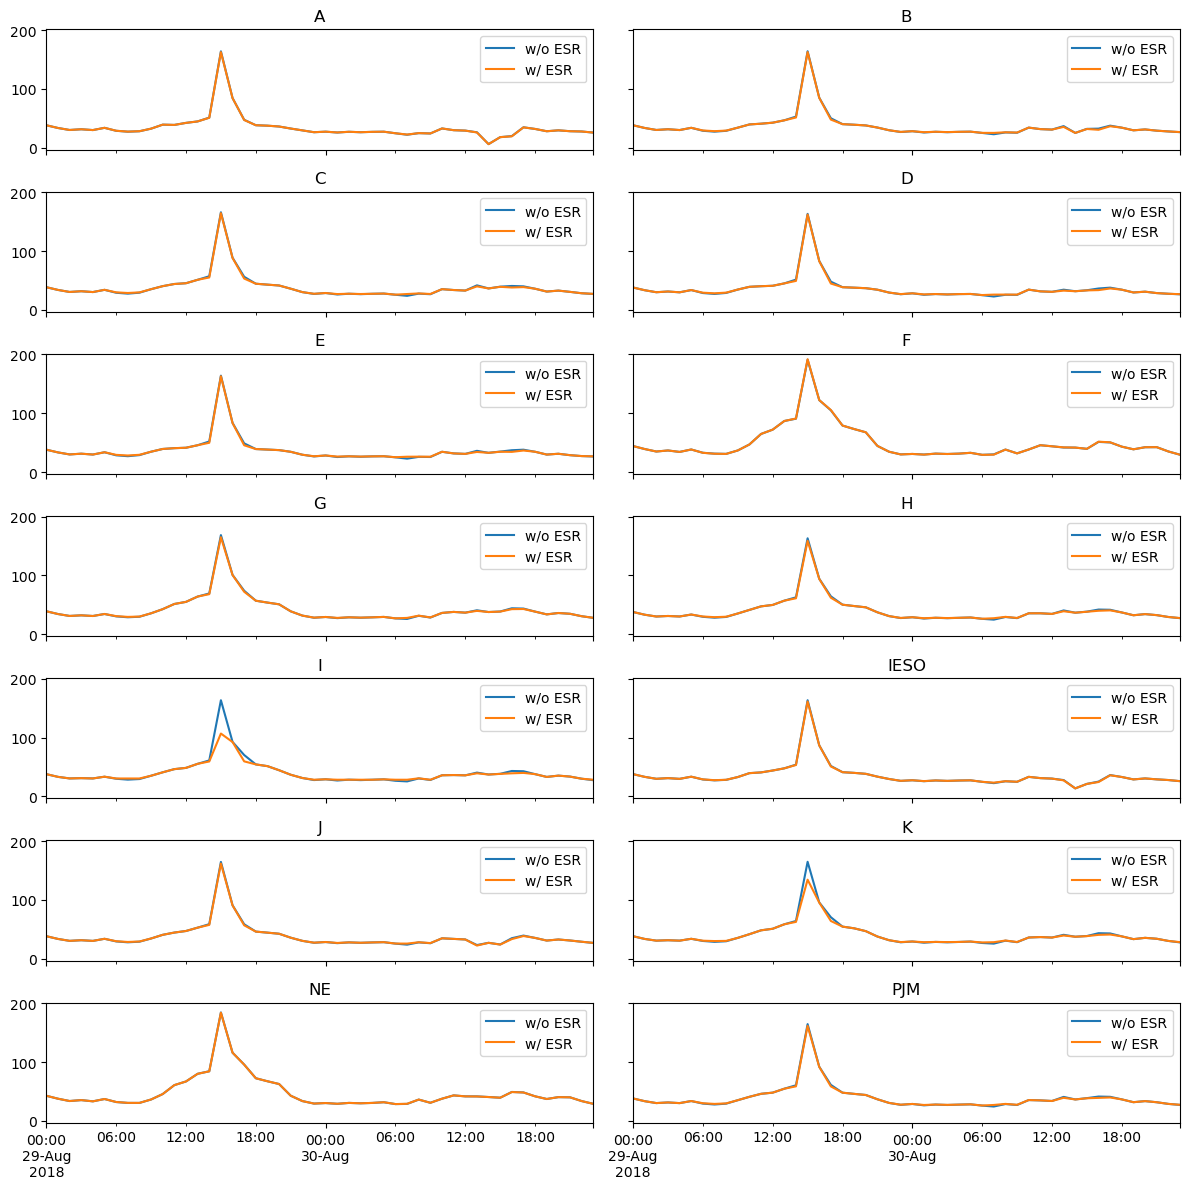

In [16]:
fig, axs = plt.subplots(7, 2, figsize=(12, 12), sharex='all', sharey='all')
# Plot LMPs w/o ESR
for i, ax in enumerate(axs.flat):
    lmp_wo_esr_zone.iloc[:, i].plot(ax=ax, label='w/o ESR')
    lmp_w_esr_zone.iloc[:, i].plot(ax=ax, label='w/ ESR')
    ax.set_title(lmp_w_esr_zone.columns[i])
    ax.legend()

fig.tight_layout()

<Axes: title={'center': 'Zonal Load'}, xlabel='TimeStamp'>

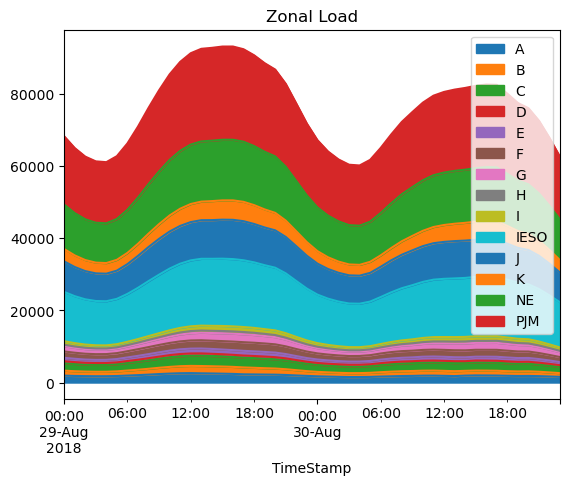

In [17]:
load_profile.columns = bus_names
load_profile_zone = load_profile.groupby(bus_zone_alloc, axis=1).sum()
load_profile_zone[start_datetime:end_datetime].plot.area(title="Zonal Load")

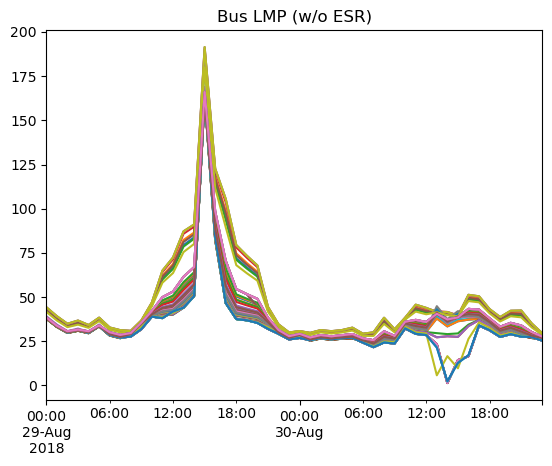

In [18]:
results_0_wo_esr['LMP'].plot(legend=False, title="Bus LMP (w/o ESR)")
plt.show()

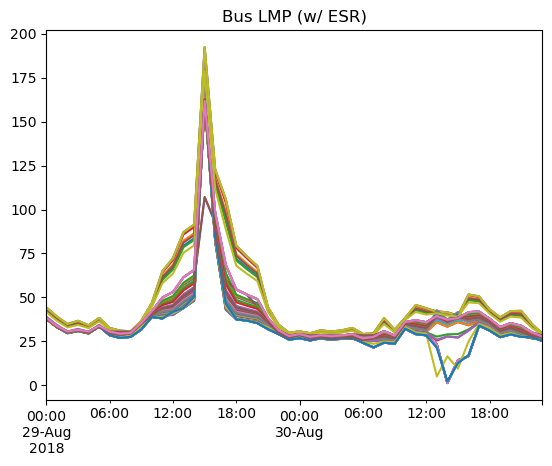

In [19]:
results_0_w_esr['LMP'].plot(legend=False, title="Bus LMP (w/ ESR)")
plt.show()

In [20]:
gen_max = genmax_profile[start_datetime:end_datetime]
gen_pg = results_0_wo_esr['PG'].iloc[:, :303]
gen_pg.columns = gen_max.columns
surplus = gen_max - gen_pg
surplus

,Gen1,Gen2,Gen3,Gen4,Gen5,Gen6,Gen7,Gen8,Gen9,Gen10,...,Gen294,Gen295,Gen296,Gen297,Gen298,Gen299,Gen300,Gen301,Gen302,Gen303
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-08-29 00:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 01:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,0.0,...,0.0,0.0,-2.220446e-16,0.000000e+00,0.000000e+00,8.881784e-16,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 02:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 03:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 04:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,-2.220446e-16,0.000000e+00,-8.881784e-16,-8.881784e-16,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 05:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,0.0,...,0.0,0.0,-2.220446e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 06:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,-3.552714e-15,0.0,0.000000e+00
2018-08-29 07:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 08:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,8.881784e-16,0.0,0.000000e+00,0.0,0.000000e+00


### With initial conditions

In [21]:
# Only run for one day
d = d+1
start_datetime = timestamp_list[d]
end_datetime = start_datetime + timedelta(hours=47)
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-08-30 00:00:00
End time: 2018-08-31 23:00:00


#### Without ESR

In [22]:
# Create NYGrid object
nygrid_sim_1_wo_esr = NYGrid(grid_data_dir,
                             start_datetime=start_datetime,
                             end_datetime=end_datetime,
                             esr_prop=None,
                             verbose=True)

# Set load and generation time series data
nygrid_sim_1_wo_esr.set_load_sch(load_profile)
nygrid_sim_1_wo_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_wo_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_wo_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_wo_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_wo_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_wo_esr.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_wo_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_wo_esr.set_gen_init_data(gen_init=last_gen)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_wo_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_wo_esr.solve_dc_opf()

# Get results
results_1_wo_esr = nygrid_sim_1_wo_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmp0z65272m.pyomo.lp
Reading time = 0.26 seconds
x1: 80880 rows, 65521 columns, 404442 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 80880 rows, 65521 columns and 404442 nonzeros
Model fingerprint: 0xebd233e2
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 74655 rows and 49888 columns
Presolve time: 0.12s
Presolved: 6225 rows, 15633 columns, 62119 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.676e+04
 Factor NZ  : 2.124e+05 (rou

In [23]:
print("s_ramp_up", results_1_wo_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_wo_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_wo_esr['s_over_gen'].sum())
print("s_load_shed", results_1_wo_esr['s_load_shed'].sum())
print("s_if_max", results_1_wo_esr['s_if_max'].sum())
print("s_if_min", results_1_wo_esr['s_if_min'].sum())
print("s_br_max", results_1_wo_esr['s_br_max'].sum())
print("s_br_min", results_1_wo_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With ESR

In [24]:
# Create NYGrid object
nygrid_sim_1_w_esr = NYGrid(grid_data_dir,
                            start_datetime=start_datetime,
                            end_datetime=end_datetime,
                            esr_prop=esr_prop,
                            verbose=True)

# Set load and generation time series data
nygrid_sim_1_w_esr.set_load_sch(load_profile)
nygrid_sim_1_w_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_w_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_w_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_w_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_w_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_w_esr.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_w_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_w_esr.set_gen_init_data(gen_init=last_gen)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_w_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_w_esr.solve_dc_opf()

# Get results
results_1_w_esr = nygrid_sim_1_w_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpgqs1c95u.pyomo.lp
Reading time = 0.28 seconds
x1: 95310 rows, 74161 columns, 434622 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 95310 rows, 74161 columns and 434622 nonzeros
Model fingerprint: 0x46cdbdcb
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 87491 rows and 54086 columns
Presolve time: 0.14s
Presolved: 7819 rows, 20075 columns, 74666 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.364e+04
 Factor NZ  : 3.166e+05 (rou

In [25]:
print("s_ramp_up", results_1_w_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_w_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_w_esr['s_over_gen'].sum())
print("s_load_shed", results_1_w_esr['s_load_shed'].sum())
print("s_if_max", results_1_w_esr['s_if_max'].sum())
print("s_if_min", results_1_w_esr['s_if_min'].sum())
print("s_br_max", results_1_w_esr['s_br_max'].sum())
print("s_br_min", results_1_w_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


## Process the results

In [26]:
# Read thermal generator info table
filename = os.path.join(grid_data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
num_thermal = gen_info.shape[0]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i]
              for i in range(num_thermal)}
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,...,maxRamp60,HeatRateLM_1,HeatRateLM_0,HeatRateLM_R2,HeatRateQM_2,HeatRateQM_1,HeatRateQM_0,HeatRateQM_R2,useQM,start-time
0,59 St. GT 1,24138,J,Combustion Turbine,Kerosene,40.772385,-73.993028,17.1,0.0,1.710000,...,17.1,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
1,74 St. GT 1,24260,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
2,74 St. GT 2,24261,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
3,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,6.600000,...,66.0,8.218122,-14.577671,0.862443,-0.094773,15.209040,-125.857658,0.891407,1,10m
4,Allied Frozen Storage,23774,A,Internal Combustion,Natural Gas,42.842029,-78.722673,0.1,0.0,0.010000,...,0.1,8.899000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Vernon Blvd 3,24163,J,Combustion Turbine,Natural Gas,40.753900,-73.950600,42.0,15.0,0.558333,...,33.5,17.272897,-319.572736,0.893510,0.524043,-14.979198,132.238854,0.935802,1,over
223,Wading River 1,23522,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,102.0,9.0,1.258333,...,75.5,12.779330,-5.232355,0.960069,-0.051615,18.026301,-96.225639,0.967170,1,over
224,Wading River 2,23547,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,7.8,1.350000,...,81.0,13.381103,-32.778267,0.981323,-0.027035,15.957351,-73.206752,0.982889,1,over
225,Wading River 3,23601,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,4.0,1.333333,...,80.0,12.154083,-11.601042,0.822005,-0.022269,14.190789,-39.250293,0.821057,1,over


In [27]:
# Format results
thermal_pg_0_wo_esr = (results_0_wo_esr['PG'].iloc[:, :num_thermal]
                       .rename(columns=gen_rename))

thermal_pg_0_w_esr = (results_0_w_esr['PG'].iloc[:, :num_thermal]
                      .rename(columns=gen_rename))

thermal_pg_1_wo_esr = (results_1_wo_esr['PG'].iloc[:, :num_thermal]
                       .rename(columns=gen_rename))

thermal_pg_1_w_esr = (results_1_w_esr['PG'].iloc[:, :num_thermal]
                      .rename(columns=gen_rename))

,59 St. GT 1,74 St. GT 1,74 St. GT 2,Allegany,Allied Frozen Storage,Arthur Kill Cogen,Arthur Kill GT 1,Arthur Kill ST 2,Arthur Kill ST 3,Astoria 2,...,St. Elizabeth Medical Center,Sterling,Stony Brook (BTM:NG),Syracuse,Vernon Blvd 2,Vernon Blvd 3,Wading River 1,Wading River 2,Wading River 3,West Babylon 4
2018-08-29 00:00:00,0.0,0.0,0.0,66.0,0.1,11.1,20.0,349.0,539.0,153.0,...,0.6,43.0,46.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-29 01:00:00,0.0,0.0,0.0,66.0,0.1,11.1,0.0,349.0,539.0,153.0,...,0.6,43.0,46.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-29 02:00:00,0.0,0.0,0.0,66.0,0.1,11.1,0.0,349.0,539.0,1.0,...,0.6,43.0,46.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-29 03:00:00,0.0,0.0,0.0,66.0,0.1,11.1,0.0,349.0,539.0,1.0,...,0.6,43.0,46.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-29 04:00:00,0.0,0.0,0.0,66.0,0.1,11.1,0.0,349.0,539.0,1.0,...,0.6,43.0,46.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0


,59 St. GT 1,74 St. GT 1,74 St. GT 2,Allegany,Allied Frozen Storage,Arthur Kill Cogen,Arthur Kill GT 1,Arthur Kill ST 2,Arthur Kill ST 3,Astoria 2,...,St. Elizabeth Medical Center,Sterling,Stony Brook (BTM:NG),Syracuse,Vernon Blvd 2,Vernon Blvd 3,Wading River 1,Wading River 2,Wading River 3,West Babylon 4
2018-08-29 00:00:00,0.0,0.0,0.0,66.0,0.1,11.1,20.0,349.0,539.0,153.0,...,0.6,43.0,46.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-29 01:00:00,0.0,0.0,0.0,66.0,0.1,11.1,0.0,349.0,539.0,153.0,...,0.6,43.0,46.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-29 02:00:00,0.0,0.0,0.0,66.0,0.1,11.1,0.0,349.0,539.0,1.0,...,0.6,43.0,46.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-29 03:00:00,0.0,0.0,0.0,66.0,0.1,11.1,0.0,349.0,539.0,1.0,...,0.6,43.0,46.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-29 04:00:00,0.0,0.0,0.0,66.0,0.1,11.1,0.0,349.0,539.0,1.0,...,0.6,43.0,46.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0


,59 St. GT 1,74 St. GT 1,74 St. GT 2,Allegany,Allied Frozen Storage,Arthur Kill Cogen,Arthur Kill GT 1,Arthur Kill ST 2,Arthur Kill ST 3,Astoria 2,...,St. Elizabeth Medical Center,Sterling,Stony Brook (BTM:NG),Syracuse,Vernon Blvd 2,Vernon Blvd 3,Wading River 1,Wading River 2,Wading River 3,West Babylon 4
2018-08-30 00:00:00,0.0,0.0,0.0,66.0,0.0,11.1,0.0,349.0,539.0,1.0,...,0.6,15.0,30.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-30 01:00:00,0.0,0.0,0.0,66.0,0.0,0.0,0.0,349.0,1.0,1.0,...,0.0,15.0,30.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-30 02:00:00,0.0,0.0,0.0,66.0,0.0,11.1,0.0,349.0,539.0,1.0,...,0.0,15.0,30.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-30 03:00:00,0.0,0.0,0.0,66.0,0.0,11.1,0.0,349.0,539.0,1.0,...,0.0,15.0,30.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-30 04:00:00,0.0,0.0,0.0,66.0,0.0,11.1,0.0,349.0,539.0,1.0,...,0.0,15.0,30.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0


,59 St. GT 1,74 St. GT 1,74 St. GT 2,Allegany,Allied Frozen Storage,Arthur Kill Cogen,Arthur Kill GT 1,Arthur Kill ST 2,Arthur Kill ST 3,Astoria 2,...,St. Elizabeth Medical Center,Sterling,Stony Brook (BTM:NG),Syracuse,Vernon Blvd 2,Vernon Blvd 3,Wading River 1,Wading River 2,Wading River 3,West Babylon 4
2018-08-30 00:00:00,0.0,0.0,0.0,66.0,0.0,11.1,0.0,349.0,539.0,1.0,...,0.6,15.0,30.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-30 01:00:00,0.0,0.0,0.0,66.0,0.0,0.0,0.0,349.0,1.0,1.0,...,0.0,15.0,30.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-30 02:00:00,0.0,0.0,0.0,66.0,0.0,11.1,0.0,349.0,539.0,1.0,...,0.0,15.0,30.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-30 03:00:00,0.0,0.0,0.0,66.0,0.0,11.1,0.0,349.0,539.0,1.0,...,0.0,15.0,30.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-30 04:00:00,0.0,0.0,0.0,66.0,0.0,11.1,0.0,349.0,539.0,1.0,...,0.0,15.0,30.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0


NYISOName              Allegany
PTID                      23514
Zone                          B
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                42.5083
Longitude              -78.0661
maxPower                   66.0
minPower                   11.0
maxRampAgc                  6.6
maxRamp10                  66.0
maxRamp30                  66.0
maxRamp60                  66.0
HeatRateLM_1           8.218122
HeatRateLM_0         -14.577671
HeatRateLM_R2          0.862443
HeatRateQM_2          -0.094773
HeatRateQM_1           15.20904
HeatRateQM_0        -125.857658
HeatRateQM_R2          0.891407
useQM                         1
start-time                  10m
Name: 3, dtype: object

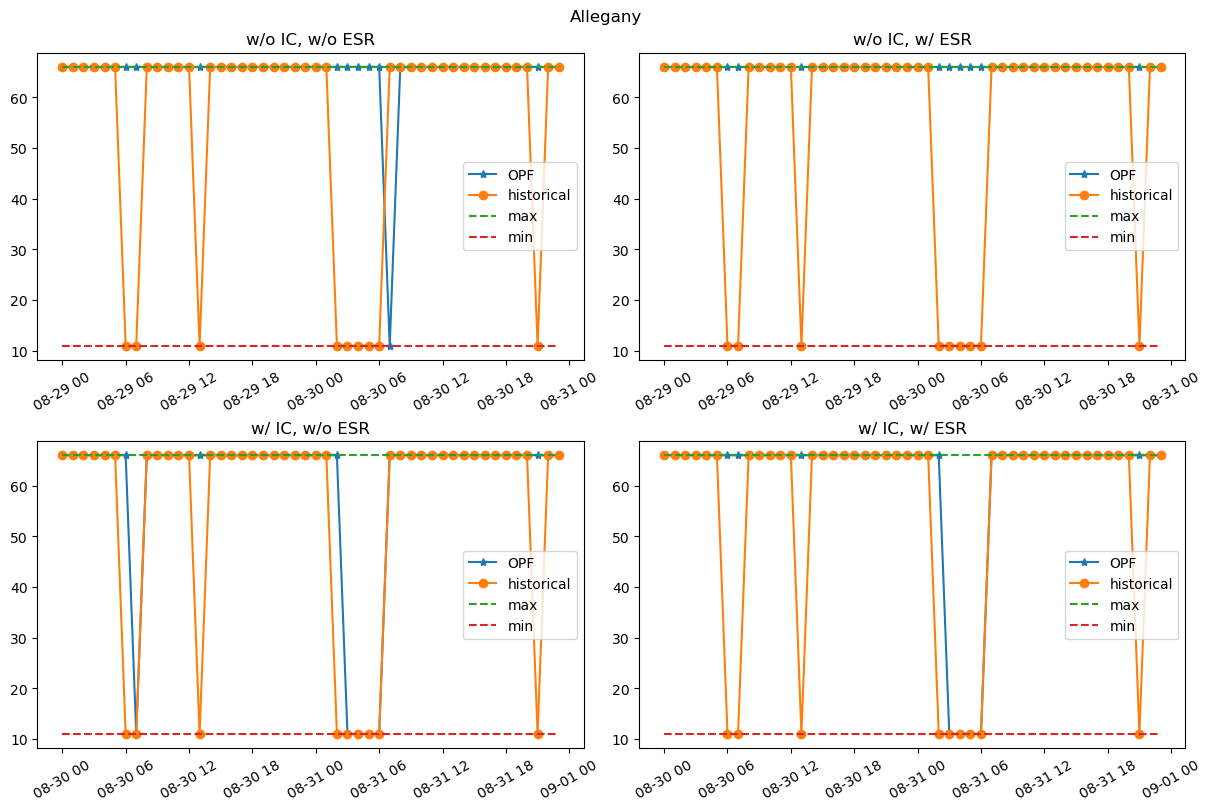

In [40]:
ii = 3
display(gen_info.iloc[ii, :])

fig, axs = plt.subplots(2, 2, figsize=(12, 8), layout='constrained')

axs[0, 0] = plot_gen(thermal_pg_0_wo_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 0], title="w/o IC, w/o ESR")
axs[0, 1] = plot_gen(thermal_pg_0_w_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 1], title="w/o IC, w/ ESR")
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 0], title="w/ IC, w/o ESR")
axs[1, 1] = plot_gen(thermal_pg_1_w_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 1], title="w/ IC, w/ ESR")
for ax in axs.flat:
    ax.tick_params(axis='x', rotation=30)
fig.suptitle(f'{gen_info.NYISOName[ii]}')
fig.show()

NYISOName            Astoria 2
PTID                     24149
Zone                         J
UnitType         Steam Turbine
FuelType           Natural Gas
Latitude               40.7869
Longitude             -73.9122
maxPower                 153.0
minPower                   1.0
maxRampAgc                15.3
maxRamp10                153.0
maxRamp30                153.0
maxRamp60                153.0
HeatRateLM_1         10.720159
HeatRateLM_0        147.545513
HeatRateLM_R2         0.987563
HeatRateQM_2          0.007555
HeatRateQM_1          9.621049
HeatRateQM_0        170.560114
HeatRateQM_R2          0.98891
useQM                        1
start-time                 10m
Name: 9, dtype: object

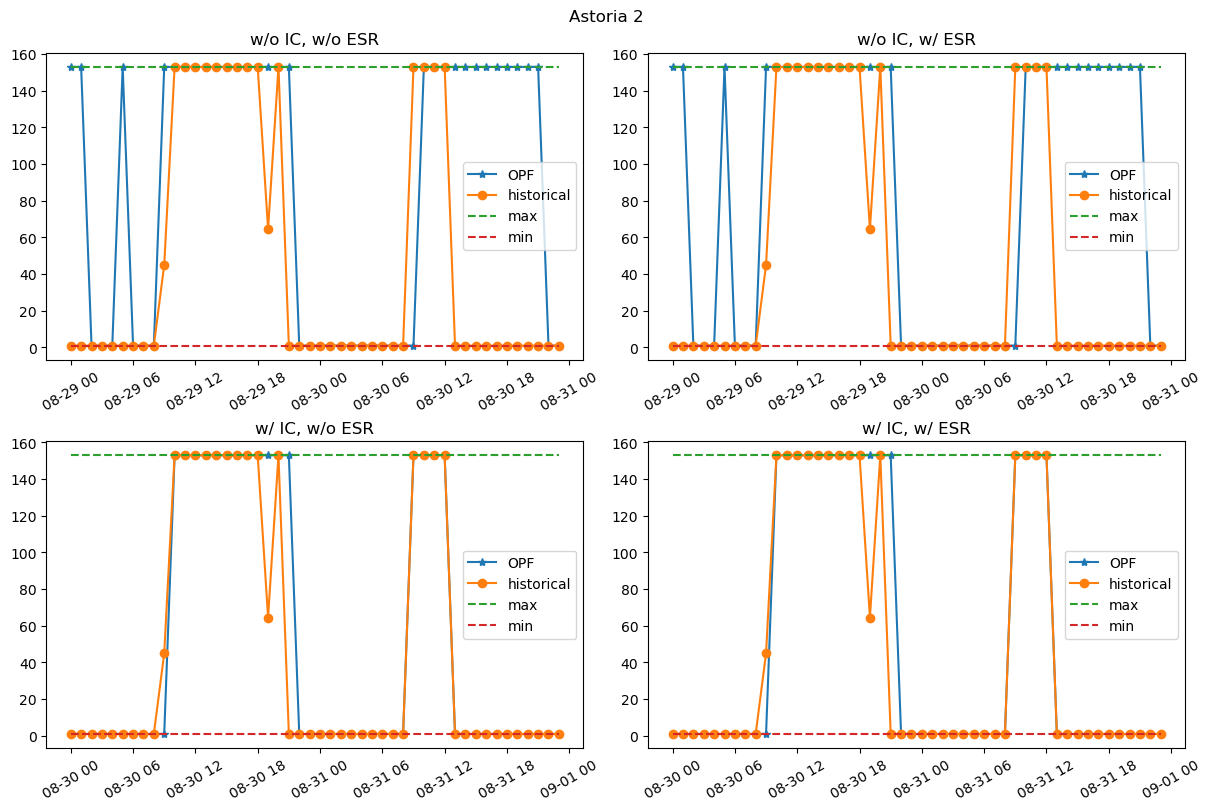

In [39]:
ii = 9
display(gen_info.iloc[ii, :])

fig, axs = plt.subplots(2, 2, figsize=(12, 8), layout='constrained')

axs[0, 0] = plot_gen(thermal_pg_0_wo_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 0], title="w/o IC, w/o ESR")
axs[0, 1] = plot_gen(thermal_pg_0_w_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 1], title="w/o IC, w/ ESR")
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 0], title="w/ IC, w/o ESR")
axs[1, 1] = plot_gen(thermal_pg_1_w_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 1], title="w/ IC, w/ ESR")
for ax in axs.flat:
    ax.tick_params(axis='x', rotation=30)

fig.suptitle(f'{gen_info.NYISOName[ii]}')
fig.show()

NYISOName          East River 2
PTID                     323559
Zone                          J
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                40.7281
Longitude              -73.9742
maxPower                  227.0
minPower                   83.0
maxRampAgc                2.325
maxRamp10                 23.25
maxRamp30                 69.75
maxRamp60                 139.5
HeatRateLM_1           7.653993
HeatRateLM_0         446.985488
HeatRateLM_R2           0.98562
HeatRateQM_2           0.006054
HeatRateQM_1           5.870358
HeatRateQM_0          567.52178
HeatRateQM_R2          0.986302
useQM                         1
start-time                  12h
Name: 83, dtype: object

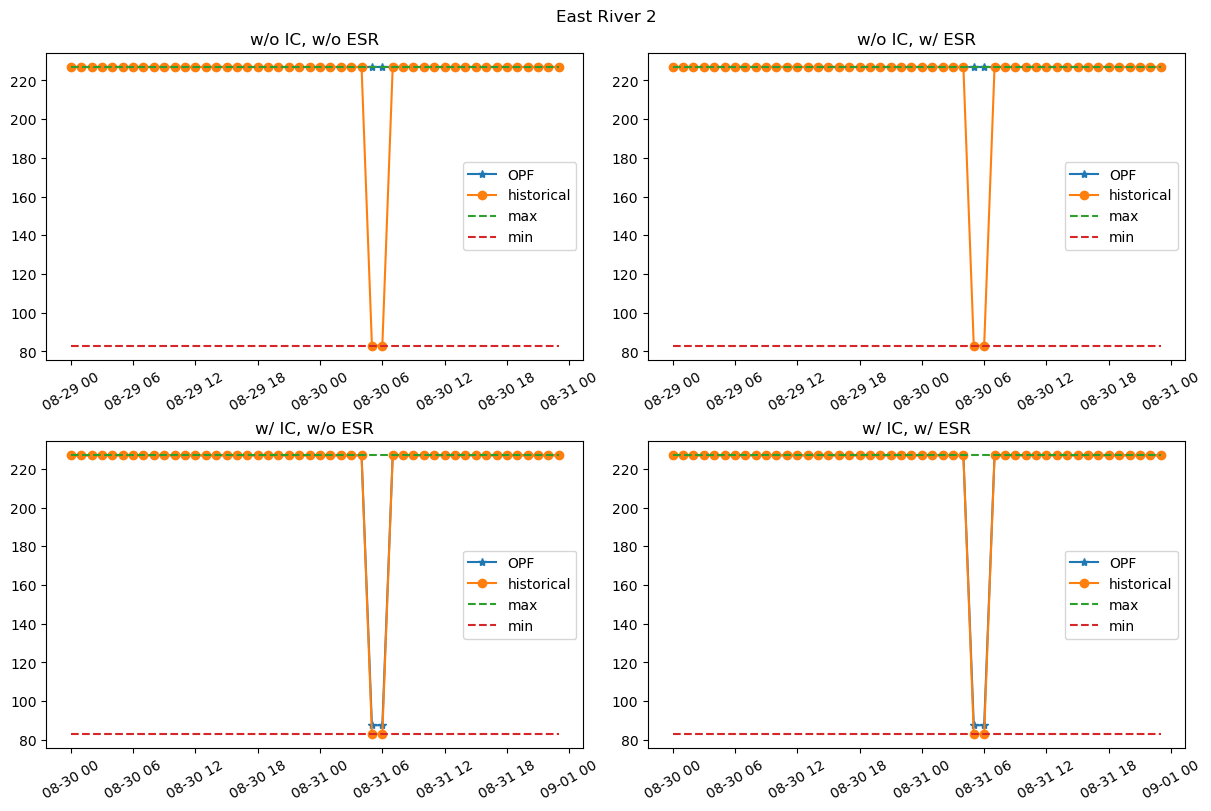

In [41]:
ii = 83
display(gen_info.iloc[ii, :])

fig, axs = plt.subplots(2, 2, figsize=(12, 8), layout='constrained')

axs[0, 0] = plot_gen(thermal_pg_0_wo_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 0], title="w/o IC, w/o ESR")
axs[0, 1] = plot_gen(thermal_pg_0_w_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 1], title="w/o IC, w/ ESR")
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 0], title="w/ IC, w/o ESR")
axs[1, 1] = plot_gen(thermal_pg_1_w_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 1], title="w/ IC, w/ ESR")
for ax in axs.flat:
    ax.tick_params(axis='x', rotation=30)
fig.suptitle(f'{gen_info.NYISOName[ii]}')
fig.show()